In [4]:
import sys
sys.path.insert(0, './scripts')

In [5]:
from helpers import get_data, mean_abs_error
from preprocessor import preprocessor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Create Model Object

Now this is the fun part, where all our careful work to ensure we lived into good code standards pays off. We'll use a Scikit-Learn Pipeline to combine the preprocessing and GBM steps into one package.

The pipeline object called my_model implements fit and predict methods (among others). When we call the fit method, the pipeline will execute preprocessor.fit_transform() on the data we pass in the arguments, then pass that result to GradientBoostingRegressor.fit(). Similarly, when we call the predict method, it will execute preprocessor.transform() and then GradientBoostingRegressor.predict().

Another major benefit of living into the fit, transform, predict paradigm of Scikit-Learn is that you can add other preprocessing steps (like PCA or some other feature transformation) into the pipeline with little modification to existing code. Finally, if any of the steps required parameter tuning (like chosing the number of principal components to use in your model), you can tune them all at once by implementing the steps in a pipeline then using a parameter selection method like Grid Search on the entire pipeline.

In [6]:
p = preprocessor(cols_to_filter=['rawcensustractandblock', 'censustractandblock', 'propertyzoningdesc', 
                                 'regionidneighborhood', 'regionidzip', 'parcelid'], datecols=['transactiondate'])

gbm = GradientBoostingRegressor(n_estimators=1000, max_depth=3, learning_rate=0.1, loss='lad', subsample=0.5)

my_model = Pipeline(steps=[('preprocessor', p),('regressor', gbm)])

## Fit Final Model

In [7]:
X_train, y_train = get_data('train')

C:\Users\sac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
my_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 <preprocessor.preprocessor object at 0x000000463E1173C8>),
                ('regressor',
                 GradientBoostingRegressor(loss='lad', n_estimators=1000,
                                           subsample=0.5))])

## Score Test Dataset
We should only do this once or a handful of times because it's possible to overfit the test set. Remember this is the test dataset that was released after the competition was over, but is not the same format as what is scored as part of the competition. Our final evaluation will be making a Kaggle submission, however we can use this test set to visualize our model results on an out-of-time test set, meaning this data is from another time period as the data we trained the model on.

In [9]:
X_test, y_test = get_data('test')
y_pred = my_model.predict(X_test)

C:\Users\sac\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Evaluate Model 

In [10]:
# Using the naive median prediction method
mean_abs_error(y_test, y_train.median())

0.06970475324840694

In [11]:
# using our actual model
mean_abs_error(y_test, y_pred)

0.06933217248453577

## Plot the Model Results

__Actuals vs. Predictions__

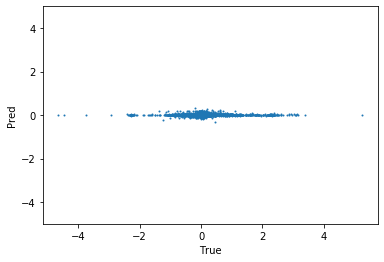

In [12]:
plt.scatter(y_test, y_pred, s=1)
plt.ylim(-5, 5)
plt.xlabel('True')
plt.ylabel("Pred")
plt.show()

This plot shows exactly where our lack of predictive power is coming from: our model is predicting everything really close to the average or median (probably median given our choice of loss function) instead of making useful predictions.

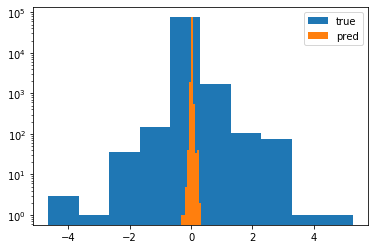

In [13]:
def plot_hists(y_test, y_pred):
    
    plt.hist(y_test, label='true')
    plt.hist(y_pred, label='pred')
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_hists(y_test, y_pred)

Notice how our model predictions have far less variance than our true response values.

In [14]:
import joblib   # Compared to pickle, joblib works more efficient on objects that carry large numpy arrays internally.

In [15]:
joblib.dump(my_model, 'models/model.pkl')

['models/model.pkl']